In [ ]:
# dataset : https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste/data?select=Clams
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Function to count images in each class
def count_images_per_class(dataset_dir):
    class_counts = {}
    classes = os.listdir(dataset_dir)
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            num_images = len(images)
            class_counts[class_name] = num_images
    return class_counts

def visualize_data(class_counts):
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


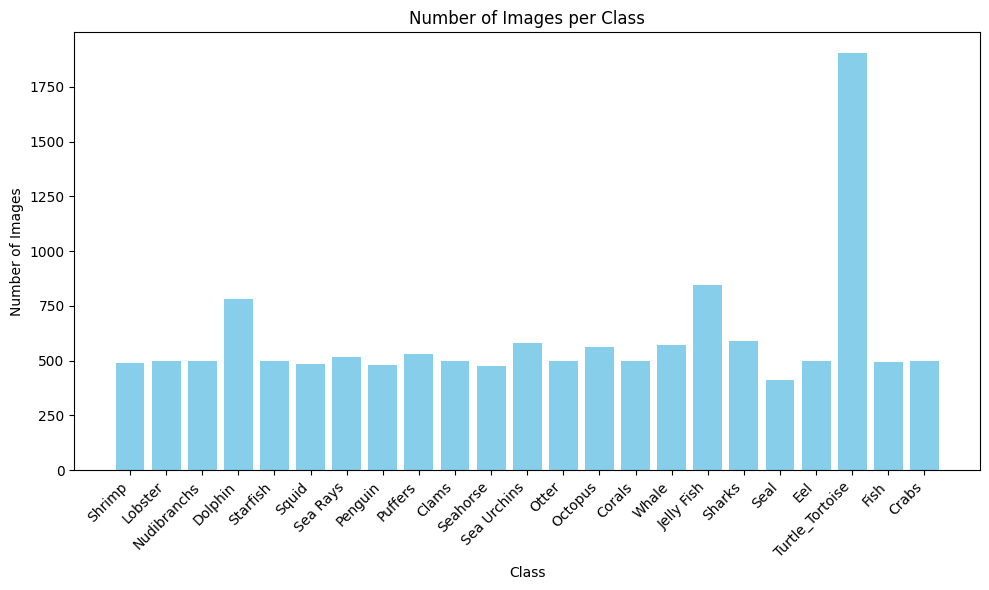

In [3]:
# Get the counts
class_counts = count_images_per_class('Datasets/Dataset')
visualize_data(class_counts)

In [ ]:
# Path to your dataset directory
dataset_dir = "Datasets/Dataset"
# Path to save augmented dataset
output_dir = "Datasets/Balanced_Dataset"

# Function to create directory if not exists
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to perform image augmentation
def augment_image(image, intensity):
    augmented_images = []
    # Original image
    augmented_images.append(image)

    if intensity == 0:return augmented_images
    # Rotation
    rows, cols, _ = image.shape
    
    for _ in range(intensity):
        random_augmentation = np.random.choice(['rotation', 'scaling', 'noise'])

        if random_augmentation == 'rotation':
            angle = np.random.choice([-15, 15])  # Adjust rotation angle as needed
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            rotated_image = cv2.warpAffine(image, M, (cols, rows))
            augmented_images.append(rotated_image)
        elif random_augmentation == 'scaling':
            scale_factor = np.random.uniform(0.5, 1.5)  # Adjust scale factor as needed
            scaled_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
            augmented_images.append(scaled_image)
        elif random_augmentation == 'noise':
            noise = np.random.normal(loc=0, scale=20, size=image.shape)  # Adjust noise intensity as needed
            noisy_image = np.clip((image + noise).astype(np.uint8), 0, 255)
            augmented_images.append(noisy_image)

    return augmented_images

# Function to augment and save images for each class
def augment_and_save_images(dataset_dir, output_dir):
    classes = os.listdir(dataset_dir)
    max_class_count = max(count_images_per_class(dataset_dir).values)
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            # Create class directory in output directory
            output_class_dir = os.path.join(output_dir, class_name)
            create_directory(output_class_dir)
            
            images = os.listdir(class_dir)
            class_count = len(images)
            # Determine augmentation intensity based on class size
            if max_class_count == class_count:
                intensity = 0
            else:
                intensity = min((max_class_count // class_count), 2)
                
            for image_name in images:
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    augmented_images = augment_image(image, intensity=intensity)
                    # Save augmented images
                    for i, augmented_image in enumerate(augmented_images):
                        augmented_image_path = os.path.join(output_class_dir, f"{os.path.splitext(image_name)[0]}_{i}.jpg")
                        cv2.imwrite(augmented_image_path, augmented_image)

# Create output directory
create_directory(output_dir)

# Augment and save images
augment_and_save_images(dataset_dir, output_dir)

print("Augmented dataset saved successfully.")

# Augmented Dataset
class_counts = count_images_per_class("Balanced_Dataset")
visualize_data(class_counts)

In [ ]:
# Path to your dataset directory
dataset_dir = "Datasets/Balanced_Dataset"
# Path to save preprocessed dataset
preprocessed_dir = "Datasets/Preprocessed_Dataset"

# Function to create directory if not exists
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to preprocess an image
def preprocess_image(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(gray_image)
    return equalized_image

# Function to preprocess and save images for each class
def preprocess_and_save_images(dataset_dir, preprocessed_dir):
    classes = os.listdir(dataset_dir)
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            # Create class directory in preprocessed directory
            output_class_dir = os.path.join(preprocessed_dir, class_name)
            create_directory(output_class_dir)
            
            images = os.listdir(class_dir)
            for image_name in images:
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    # Preprocess image
                    preprocessed_image = preprocess_image(image)
                    # Save preprocessed image
                    output_image_path = os.path.join(output_class_dir, image_name)
                    cv2.imwrite(output_image_path, preprocessed_image)

# Create output directory
create_directory(preprocessed_dir)

# Preprocess and save images
preprocess_and_save_images(dataset_dir, preprocessed_dir)

print("Preprocessed dataset saved successfully.")


In [4]:
# Function to create directory if not exists
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to compute LBP features
def compute_lbp_features(image):
    try:
        radius = 1
        num_points = 8 * radius
        lbp_image = np.zeros_like(image)
        for i in range(1, image.shape[0] - 1):
            for j in range(1, image.shape[1] - 1):
                center = image[i, j]
                pattern = 0
                for (x, y) in [(i-1, j), (i-1, j+1), (i, j+1), (i+1, j+1), (i+1, j), (i+1, j-1), (i, j-1), (i-1, j-1)]:
                    pattern <<= 1
                    if image[x, y] >= center:
                        pattern |= 1
                lbp_image[i, j] = pattern
        lbp_hist, _ = np.histogram(lbp_image, bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
        return lbp_hist
    except:
        return None

# Path to your preprocessed dataset directory
preprocessed_dir = "Preprocessed_Dataset"
# Path to save LBP features
lbp_output_dir = "LBP_Features"

# Create output directories if not exists
create_directory(lbp_output_dir)

# Iterate through each class in the preprocessed dataset
classes = os.listdir(preprocessed_dir)
for class_name in classes:
    class_dir = os.path.join(preprocessed_dir, class_name)
    if os.path.isdir(class_dir):
        # Create class directories in output directories
        lbp_class_dir = os.path.join(lbp_output_dir, class_name)
        create_directory(lbp_class_dir)
        
        # Iterate through each preprocessed image in the class directory
        images = os.listdir(class_dir)
        for image_name in images:
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                # Compute LBP features
                lbp_features = compute_lbp_features(image)
                # Save LBP features
                if lbp_features is not None:
                   lbp_output_path = os.path.join(lbp_class_dir, f"{os.path.splitext(image_name)[0]}.npy")
                   np.save(lbp_output_path, lbp_features)

print("LBP features extracted and saved successfully.")

In [ ]:
# Paths to dataset and output
dataset_dir = "Datasets/Preprocessed_Dataset"
output_csv = "deep_cnn_features.csv"

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False, pooling='avg')  # Use global average pooling

# Function to extract features from an image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to VGG16 input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array = preprocess_input(img_array)  # Preprocess input for VGG16 model
    features = model.predict(img_array)  # Extract features using pre-trained VGG16 model
    return features.flatten()  # Flatten feature vector

# Prepare to store features and labels
features_list = []
labels_list = []

# Iterate through each class in the dataset
classes = os.listdir(dataset_dir)
for class_name in tqdm(classes, desc="Processing classes"):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        # Iterate through each image in the class directory
        images = os.listdir(class_dir)
        for image_name in tqdm(images, desc=f"Processing images in class {class_name}", leave=False):
            image_path = os.path.join(class_dir, image_name)
            features = extract_features(image_path)  # Extract features from the image
            features_list.append(features)  # Add features to the list
            labels_list.append(class_name)  # Add label to the list

# Convert to DataFrame
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_list

# Save to CSV
features_df.to_csv(output_csv, index=False)

print(f"Deep CNN features saved to {output_csv}.")


In [ ]:
# Paths to directories containing HOG and LBP features
lbp_dir = "LBP_Features"
# Paths to save transformed features
output_lbp_csv = "lbp_features_transformed.csv"

# Function to load features from directory
def load_features(directory):
    features = []
    labels = []
    classes = os.listdir(directory)
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Iterate through each feature file in the class directory
            images = os.listdir(class_dir)
            for image_name in images:
                feature_path = os.path.join(class_dir, image_name)
                feature = np.load(feature_path)
                features.append(feature)
                labels.append(class_name)
    return np.array(features), np.array(labels)

# Load HOG and LBP features
lbp_features, lbp_labels = load_features(lbp_dir)

# Ensure the labels are numeric
lbp_labels_numeric = pd.factorize(lbp_labels)[0]

# Perform PCA on HOG features
pca = PCA(n_components=0.95)  # Keep 95% of variance
# Perform PCA on LBP features
lbp_features_pca = pca.fit_transform(lbp_features)

# Perform ICA on LBP features
ica = FastICA(n_components=min(lbp_features.shape[1], len(np.unique(lbp_labels))))
lbp_features_ica = ica.fit_transform(lbp_features)

lda = LDA()
# Perform LDA on LBP features
lbp_features_lda = lda.fit_transform(lbp_features, lbp_labels_numeric)

qda = QDA()
lbp_qda = qda.fit(lbp_features, lbp_labels_numeric)

# Save transformed LBP features to CSV
lbp_df = pd.DataFrame(lbp_features_pca, columns=[f"lbp_pca_{i+1}" for i in range(lbp_features_pca.shape[1])])
lbp_df_ica = pd.DataFrame(lbp_features_ica, columns=[f"lbp_ica_{i+1}" for i in range(lbp_features_ica.shape[1])])
lbp_df_lda = pd.DataFrame(lbp_features_lda, columns=[f"lbp_lda_{i+1}" for i in range(lbp_features_lda.shape[1])])
lbp_df['label'] = lbp_labels
lbp_df_ica['label'] = lbp_labels
lbp_df_lda['label'] = lbp_labels

lbp_df.to_csv("lbp_features_pca.csv", index=False)
lbp_df_ica.to_csv("lbp_features_ica.csv", index=False)
lbp_df_lda.to_csv("lbp_features_lda.csv", index=False)

print("Transformed features saved successfully.")


In [ ]:
# Paths to CSV files
hog_pca_csv = "hog_features_pca.csv"
hog_ica_csv = "hog_features_ica.csv"
hog_lda_csv = "hog_features_lda.csv"
lbp_pca_csv = "lbp_features_pca.csv"
lbp_ica_csv = "lbp_features_ica.csv"
lbp_lda_csv = "lbp_features_lda.csv"
deep_cnn_csv = "deep_cnn_features.csv"

# Function to train and evaluate SVM on given features with different kernels
def train_and_evaluate_svm(features_csv, kernels):
    results = {}
    
    # Load features
    df = pd.read_csv(features_csv)
    X = df.drop(columns=['label'])
    y = df['label']
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for kernel in kernels:
        # Train SVM model
        svm = SVC(kernel=kernel)
        svm.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = svm.predict(X_test)
        
        # Evaluate model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        results[kernel] = {
            "Accuracy": accuracy,
            "Report": report
        }
    
    return results

# Define the kernels to be used
kernels = ['linear', 'rbf', 'poly']

# Train and evaluate SVM on each set of features with different kernels
feature_sets = {
    "HOG PCA": hog_pca_csv,
    "HOG ICA": hog_ica_csv,
    "HOG LDA": hog_lda_csv,
    "LBP PCA": lbp_pca_csv,
    "LBP ICA": lbp_ica_csv,
    "LBP LDA": lbp_lda_csv,
    "Deep CNN": deep_cnn_csv
}

all_results = {}

for name, csv_path in feature_sets.items():
    results = train_and_evaluate_svm(csv_path, kernels)
    all_results[name] = results
    for kernel, result in results.items():
        print(f"Results for {name} features with {kernel} kernel:")
        print(f"Accuracy: {result['Accuracy']}")
        print("Classification Report:")
        print(result['Report'])
        print("\n")

# Optional: Save results to a file
results_list = []
for feature_name, kernel_results in all_results.items():
    for kernel, result in kernel_results.items():
        results_list.append({
            "Feature Set": feature_name,
            "Kernel": kernel,
            "Accuracy": result["Accuracy"],
            "Report": result["Report"]
        })

results_df = pd.DataFrame(results_list)
results_df.to_csv("svm_results_with_kernels.csv", index=False)

print("SVM training and evaluation completed for all feature sets with different kernels.")